<img src="../../thu_sigs_logo.png" alt="清华深研院-横" style="zoom:50%;" />

In [ ]:
# quarto
#| hide
#| default_exp tree

In [82]:
#|hide
import matplotlib.pyplot as plt
plt.style.use('default')

## 实验目的
> 老师给我们的要求是
> 1. 完成 KD 树算法，并利⽤实现的算法完成数字识别任务
> 2. 对所建模型进行分析评判。

我们

## 实验数据
> MNIST 数据库是由 Yann et. al. 提供的⼿写数字数据库⽂件, 官网地址为。
> 主要包含了 60000 张的训练图像和 10000 张的测试图像
> ```python
> from sklearn.datasets import fetch_openml
> from sklearn.model_selection import train_test_split
> from sklearn.neighbors import KNeighborsClassifier
> from sklearn.metrics import accuracy_score
> import numpy as np
> # 获取MNIST数据集,并抽样一部分数据以便后续的计算
> idx = np.random.choice(70000,5000,replace=False)
> mnist = fetch_openml("mnist_784")
> X, y = mnist.data.to_numpy(), mnist.target.to_numpy().astype('int')
> X = X[idx]
> y = y[idx]
> # 划分数据集为训练集和测试集
> X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
> 
> ```



以上代码有几个小问题，我们需要改进一下
1. 由于网络环境问题，fetch_openml("mnist_784") 是无法跑通的，会卡死。
事实上，给sklearn贡献过代码的同学可能知道，sklearn还有一个load_digits数据集，这个数据集是sklearn CI（持续集成）测试用例的一部分。这个回归测试通过测试贡献者的新做的改进是否导致性能不如以前的版本，来决定是否接受更改。
因此，我们使用load_digits数据集代替mnist_784数据集来完成这个项目。

https://scikit-learn.org/1.5/modules/generated/sklearn.datasets.load_digits.html

2. 划分数据集时，train_test_split应当使用stratify参数，以确保每一类样本的比例相同。
3. import过多，应该只导入需要的模块。

In [1]:
#| export
from sklearn.datasets import load_digits
dataset_dict = load_digits()
dataset_dict.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [2]:
#| export
import numpy as np
X:np.array = dataset_dict['data']
y:np.array = dataset_dict['target']
X.shape, X.dtype, y.shape, y.dtype

((1797, 64), dtype('float64'), (1797,), dtype('int64'))

划分数据集为训练集和测试集

In [3]:
#| export
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, 
                                                    stratify=y)
len(X_train), len(X_test)

(1437, 360)

## 实验内容
### KNN和KD树的关系是什么？什么叫基于KD树的KNN算法？

在我们开始实验内容之前，有必要澄清这一理论上的概念。



### 基于sklearn的KNN算法实现手写数字识别

In [4]:
#| export
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
# 创建KNeighborsClassifier模型，使用kd树作为搜索算法
knn = KNeighborsClassifier(n_neighbors=3, algorithm='kd_tree')

# 在训练集上训练模型
knn.fit(X_train, y_train)

# 在测试集上进行预测
y_pred = knn.predict(X_test)

# 评估模型性能
accuracy = accuracy_score(y_test, y_pred)
print(f"KNN Accuracy: {accuracy * 100:.2f}%")

KNN Accuracy: 98.61%


### 自己实现KD树

In [5]:
#| export

# 定义KD树节点类
class Node:
    def __init__(self, data, left=None, right=None):
        self.data = data #节点本身的数据
        self.left = left #节点的左子树
        self.right = right #节点右子树

# 递归方法构建KD树

def build_kd_tree(X, depth=0):
    if len(X) == 0:
        return None
    k = X.shape[1]
    axis = depth % k #根据当前深度，选择划分的维度
    X = X[X[:, axis].argsort()]
    median = X.shape[0] // 2 #将当前结点数据一分为二
    return Node(data=X[median], left=build_kd_tree(X[:median], depth + 1), right=build_kd_tree(X[median + 1:], depth + 1))

# 计算点之间的距离，这里使用欧几里得距离
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

In [6]:
#| export
from queue import PriorityQueue
# from fastcore.utils import patch
# def __len__(self:PriorityQueue):
#     return self.qsize()
# q = PriorityQueue()
# q.put((3, 'c'))
# q.put((1, 'd'))
# q.put((2, 'b'))
# print(q.get())

# 注意一个坑点，same priority 下 会崩溃； PriorityQueue文档没写，heapq写了
# https://docs.python.org/3/library/heapq.html

In [7]:
#| export
from queue import PriorityQueue


class TestNode:
    def __init__(self, point):
        self.point = point


test1 = [
    (-13.30413469565007, 1.2),
    (-9.327379053088816, 0.0),
    (-13.30413469565007, 1.4),
]
test2 = [
    (-13.30413469565007, TestNode(1.2)),
    (-9.327379053088816, TestNode(0.0)),
    (-13.30413469565007, TestNode(1.4)),
]

test3 = [
    (0, TestNode(1.2)),
    (1, TestNode(0.0)),
    (2, TestNode(1.4)),
]

test_pq = PriorityQueue()
for t in test1:
    test_pq.put(t)
print(test_pq.get())
test_pq = PriorityQueue()
for t in test3:
    test_pq.put(t)
print(test_pq.get())
# 注意这种情况下报错
# for t in test2:
#     test_pq.put(t)
# print(test_pq.get())

(-13.30413469565007, 1.2)
(0, <__main__.TestNode object at 0x76ebb8455510>)


In [8]:
#| export
# 搜索KD树
def search_kd_tree(tree, target, k=3):
    if tree is None:
        return []
    # k_nearest = [] #list用于储存target当前遍历到的k个k近邻
    # 我们使用优先队列来储存k_nearest，从而提高效率，优先队列中的元素为(-距离, 节点)的元组，距离远的先取出来
    # k_nearest_pq = PriorityQueue(maxsize=k)
    k_nearest_pq = PriorityQueue()
    entry_count = 0
    stack = [(tree, 0)] #用于储存待遍历节点的stack
    while stack:
        node, depth = stack.pop() # 节点出栈
        if node is None:
            continue
        # print(" "*4*depth + f"node: {node.data}, depth: {depth}")
        distance = euclidean_distance(target, node.data) #计算需要分类的目标点与节点的距离
        
        # 调换到前面
        axis = depth % target.shape[0] #计算当前深度对应的划分维度
        axis_diff = target[axis] - node.data[axis] #计算该维度下目标点与当前节点的差
        
        #如果k_nearest未装满或k_nearest中相距目标点最远的点与目标点的距离大于axis_diff的绝对值时，则另一边的子树也入栈
        can_omit_another_side = True
        # if len(k_nearest) < k: # 当k_nearest未装满时，直接将节点放入
        # if k_nearest.qsize() < k: # 当k_nearest未装满时，直接将节点放入
        if k_nearest_pq.qsize() < k: # 当k_nearest未装满时，直接将节点放入
        # if not k_nearest_pq.full(): # 当k_nearest未装满时，直接将节点放入
            # print(f"not full, put {(-distance, node)}")
            pass #BLANK_1
            # k_nearest.append((node, distance))
            k_nearest_pq.put((-distance, entry_count, node))
            entry_count+=1
            can_omit_another_side = False
        else: #当k_nearest装满时，对比该节点与k_nearest中与目标点距离最远的节点的距离，如果小于则替换，如果大于则不替换
            pass #BLANK_2
            farthest = k_nearest_pq.get()
            farthest_distance = -farthest[0]
            # print(f"full, farthest: {farthest}")
            if distance < farthest_distance:
                # print(f"closer, put {(-distance, node)}")
                # assert isinstance(distance, float)
                # print(k_nearest_pq.queue)
                k_nearest_pq.put((-distance, entry_count, node))
                entry_count+=1
            else:
                k_nearest_pq.put(farthest)
            

            if farthest_distance > abs(axis_diff): 
                can_omit_another_side = False
        
        if axis_diff <= 0: #当差小于0时则，该节点的左子树入栈 #如果k_nearest未装满或k_nearest中相距目标点最远的点与目标点的距离大于axis_diff的绝对值时，则右子树也入栈
            pass #BLANK_3
            stack.append((node.left, depth+1))
            if not can_omit_another_side:
                stack.append((node.right, depth+1))
        else:#当差大于0时则，该节点的右子树入栈，#如果k_nearest未装满或k_nearest中相距目标点最远的点与目标点的距离大于axis_diff的绝对值时，则左子树也入栈
            pass #BLANK_4
            stack.append((node.right, depth+1))
            if not can_omit_another_side:
                stack.append((node.left, depth+1))
    # return [data for data, _ in k_nearest] #返回遍历完的kd树后的k_nearest
    # return [data for _, data in k_nearest] #返回遍历完的kd树后的k_nearest
    return [k_nearest_pq.get()[-1].data for i in range(k_nearest_pq.qsize())] #返回遍历完的kd树后的k_nearest

# 使用KNN算法分类
def knn_classifier(X_train, y_train, X_test, k=3):
    y_pred = []
    for i, test_point in enumerate(X_test):
        k_nearest = search_kd_tree(kd_tree, test_point, k)
        # print(k_nearest)
        # print(i)
        labels = [y_train[np.where((X_train == point).all(axis=1))[0][0]] for point in k_nearest]
        counts = np.bincount(labels)#计算k_nearest中样本最多的标签，预测目标样本为该标签
        y_pred.append(np.argmax(counts))
    return y_pred

# 构建KD树
kd_tree = build_kd_tree(X_train)


In [9]:
# k_nearest = search_kd_tree(kd_tree, X_test[7], 3)
# k_nearest

In [10]:
#| export
# 使用KNN算法进行分类
k_neighbors = 3
y_pred = knn_classifier(X_train, y_train, X_test, k_neighbors)

# 评估分类性能
accuracy = accuracy_score(y_test, y_pred)
print(f"KNN Accuracy: {accuracy * 100:.2f}%")

KNN Accuracy: 98.61%


### 超参数调优

实验题目要求我们对 knn 进⾏超参数的搜索。那么什么是超参数搜索呢？为此我们需要理解两个概念——超参数和搜索。

#### 什么是参数？什么是超参数？什么是元参数？

在大数据分析中，我们往往不知道数据的总体，只能获得数据的一个采样。然而我们对数据的总体是什么分布非常感兴趣，这些未知的分布，我们假设可能是由一些参数来决定的，我们需要根据采样出来的数据对总体的参数进行参数估计（Parameter Estimation）。比如说总体是高斯分布，那么高斯分布的均值和方差就是参数。

刚才我们说了参数是什么，那么什么是超参数呢？参数估计我们通常会用极大似然估计方法，但是相比于贝叶斯参数估计来说有一定的局限性。在贝叶斯机器学习中，我们认为参数本身也是有一个概率分布的，而不是确定的值，而描述参数分布的参数，我们称之为超参数。当然，我们可以认为超参数也有其分布，那么就有对应的超超参数，这种多层嵌套的结构称为贝叶斯网络。

对应到机器学习和深度学习中，参数是指参数化模型的权重。但是我们没有在使用贝叶斯估计，并没有说这些模型权重具有一定的分布，那么超参数是怎么一回事呢？事实上，根据谷歌团队提出的《深度学习调优指南》，深度学习社区错误地把学习率、批处理大小、正则化系数等参数叫做超参数，这是错误的。他们确实决定了模型的假设空间的不同，决定了最终的性能，而且在模型训练过程中不发生变化，而是决定了训练过程，但是他们本身并不是先验分布的参数，严格来说不应该叫做超参数，应该叫做元参数。

#### 什么是搜索？


#### KNN和KD树有哪些元参数？
上文我们辨析了KNN和KD树的关系，即是否选用KD树作为KNN的近邻搜索算法，本身是KNN的一个元参数，KNN也可以选择Ball Tree、Brute Force等其他近邻搜索算法。

KD树本身也有一些元参数，比如分割方式、节点的选择方式等，这些元参数会影响KD树的构建和搜索的系统性能（时间复杂度、空间复杂度），但是不会影响到机器学习的性能（分类准确率、ROC-AUC等指标）。因为不影响机器学习的性能，在本节我们不讨论KD树的元参数如何调优。我们会在下一节，附加题中，讨论不同的KD树构建方式对搜索速度的影响。

那么KNN作为一个机器学习算法，有哪些元参数需要调优呢？参考sklearn的KNeighborsClassifier类的参数说明，我们可以看到以下参数

In [11]:
#| exports
# help(KNeighborsClassifier)
# 使用 ipython的 ? 可以更好地看到 函数和类的docstring信息。
KNeighborsClassifier?

Init signature:
KNeighborsClassifier(
    n_neighbors=5,
    *,
    weights='uniform',
    algorithm='auto',
    leaf_size=30,
    p=2,
    metric='minkowski',
    metric_params=None,
    n_jobs=None,
)
Docstring:     
Classifier implementing the k-nearest neighbors vote.

Read more in the :ref:`User Guide <classification>`.

Parameters
----------
n_neighbors : int, default=5
    Number of neighbors to use by default for :meth:`kneighbors` queries.

weights : {'uniform', 'distance'}, callable or None, default='uniform'
    Weight function used in prediction.  Possible values:

    - 'uniform' : uniform weights.  All points in each neighborhood
      are weighted equally.
    - 'distance' : weight points by the inverse of their distance.
      in this case, closer neighbors of a query point will have a
      greater influence than neighbors which are further away.
    - [callable] : a user-defined function which accepts an
      array of distances, and returns an array of the same shape

其中这几个参数是和分类准确率有关的
- `n_neighbors`, 也就是k
- `weights`，检索出来的k个点用来决策，这些点一样重要吗？
  - 我们李航书学的基础版本是uniform，而distance方法不一样在于
  - 每一个点的投票权是距离的-1次方。（哈哈为什么不是像万有引力那样是-2次方）
- `p`和`metric`和`metric_params`, 要怎么计算距离？

而 `algorithm` `leaf_size` `n_jobs` 三个参数暂时和我们无关。

In [12]:
#| exports
from sklearn.metrics.pairwise import distance_metrics
distance_metrics().keys()

dict_keys(['cityblock', 'cosine', 'euclidean', 'haversine', 'l2', 'l1', 'manhattan', 'precomputed', 'nan_euclidean'])

#### 具体要怎么调参呢？

如果我们就把调参问题当做搜索问题，那么它就是一个无梯度黑盒最优化问题。对于这类问题，最平凡（trivial）的搜索方法是全盘遍历（grid search），然而当搜索空间太大的时候，这就不是很高效了。一些基础的改进是贪心算法和随机化搜索方法，比如爬山法、随机采样法、模拟退火法等。而要想得到最先进（SOTA）的性能，演化计算和贝叶斯优化是两个最好的方法，也是目前人工智能仍然活跃的科研方向。

然而调参问题并不完全是搜索问题。Google的《深度学习调优指南》指出，调参是一个“探索与利用”（exploration and exploitation）的过程。我的理解是，在我们做深度学习研究的时候，我们其实更想知道，我们的方法对于那些超参数敏感，在其他方法也调到最优超参的情况下我的方法是否仍然显著优于其他方法，而不只是说我的方法在单单一个超参数上优于其他方法（选择“我的方法”还是“其他近期SOTA方法”就是一个离散型目标元参数）。因此，我们需要在调参的过程中理解不同的参数对于结果的影响。这其实也是作为科学家和研究者我们做科学实验的过程。调参的实质不是乱试，而是“控制变量”，参数就是自变量和无关变量，评价指标就是因变量。不过，与我们高中生物课学习的“控制变量法”稍有不同，无关变量不一定是控制相等，在计算资源充足时，无关变量应该控制到最优，所以这里有优化问题。

对于具体的调参算法和代码而言，我们当然可以用sklearn默认提供的GridSearchCV、RandomizedSearchCV等方法，我猜做这个作业的大部分同学用的是这两个。但是刚才我们也说了，GridSearch代价太高，而RandomizedSearchCV以及贝叶斯优化、演化计算忙于“利用”，而没有进行单一变量原则，无法通过科学实验“探索”出我们想获得的insight。根据Google的建议，在探索阶段最适合的算法其实是准随机搜索算法（quasi random search）。

因此，我们遵循google指南，


此外，我还实现了一个“学生实验算法”，这个算法从优化上来说是一种交替优化（alternating optimization）或者叫做多阶段优化（multi-stage optimization）的方法，即先固定一个超参数，然后在这个超参数下进行优化，再固定另一个超参数，再进行优化，以此类推，直到所有超参数都优化完毕。这个算法的好处是遵循了单一变量原则和无关变量控制相等原则，可以探索出很多结论。


在这里我们也做一个科学实验，实验假设是在其他参数最优时，使用"distance"的KNN比普通的"uniform"KNN的效果好。
这样我们有一个研究的目标，相当于我们扮演那个提出"distance"方法的科学家，要和其他人的方法做比较才能发论文。

#### 代码实现调优

首先我们需要定义KNN元参数的分布空间

In [66]:
#| exports
from sklearn.metrics.pairwise import distance_metrics
from ray import train, tune
# https://docs.ray.io/en/latest/tune/tutorials/tune-search-spaces.html
search_space = dict(
    # weights = tune.grid_search(["uniform", "distance"]) 
    weights = tune.choice(["uniform", "distance"]) # 目标元参数， 我们的零假设是这两个distance不优于uniform，备择假设是distance更好。
    ,n_neighbors = tune.randint(1, 20)  # 随机取整数。 TODO 我们还可以用左偏正态分布来建模这个参数的先验分布。
    # ray tune也能处理条件分布，但是太复杂了，我们避免`p`参数依赖于`metric`参数生效的问题，我们换成choice来处理。
    ,distance_metric = tune.choice([k for k in distance_metrics().keys() if k not in ['precomputed', 'haversine']]) # grid_search 是要求必须遍历的，而choice是随机选择。
)

然后我们定义评价函数

In [14]:
#| hide
    # random_seed = tune.grid_search([0, 1, 2]) # 做三次实验，因为KNN还是有随机性的（主要是验证集的划分；距离一样的时候选了谁、投票平票的时候决定是哪个类别，这两个sklearn中是确定的）
    # ,
    
    
    # np.random.seed(random_state)
    # indices = np.arange(X_train.shape[0])
    # np.random.shuffle(indices)
    # scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')

In [67]:
#| export
# from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
def evaluate_knn(weights:str, n_neighbors:int, distance_metric:str, random_seed:int = 42):
    knn = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, metric=distance_metric)

    # 使用k fold交叉验证，相当于做了5次独立实验。
    kf = KFold(n_splits=5, shuffle=True, random_state=random_seed)
    
    # 初始化存储每次交叉验证的分数
    scores = []
    
    # 进行5折交叉验证
    for train_index, test_index in kf.split(X_train):
        # 分割训练集和测试集
        X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
        y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
        
        # 创建KNN分类器实例
        knn = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, metric=distance_metric)
        
        # 训练模型
        knn.fit(X_train_fold, y_train_fold)
        
        # 预测测试集
        y_pred = knn.predict(X_test_fold)
        
        # 计算准确率
        score = accuracy_score(y_test_fold, y_pred)
        scores.append(score)
    return scores
# 测试下函数能不能跑
evaluate_knn(random_seed=43, weights='uniform', n_neighbors=5, distance_metric='euclidean')

[0.9826388888888888,
 0.9861111111111112,
 0.975609756097561,
 0.975609756097561,
 0.9930313588850174]

In [68]:
#| export
# 符合optuna接口
def objective(meta_parameters):
    scores = evaluate_knn(**meta_parameters)
    return dict(
        mean_score=sum(scores)/len(scores),
        std_score=np.std(scores),
                )|{f"score_{i}":score for i,score in enumerate(scores)}

接下来我们要定义使用的搜索算法。

In [69]:
#| export
from ray.tune.search import ConcurrencyLimiter
from ray.tune.search.optuna import OptunaSearch
from optuna.samplers import QMCSampler
# quasi random search
sampler = QMCSampler()
algo = OptunaSearch(sampler=sampler)
algo = ConcurrencyLimiter(algo, max_concurrent=4)

/tmp/ipykernel_65391/1646428652.py:5: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  sampler = QMCSampler()


In [70]:
#| export
tuner = tune.Tuner(
    objective,
    tune_config=tune.TuneConfig(
        metric="mean_score",
        mode="max",
        num_samples=100,
        # num_samples=3,
        search_alg=algo,
    ),
    param_space=search_space,
)
results:tune.ResultGrid  = tuner.fit()

[W 2024-10-22 22:33:34,289] The parameter 'weights' in trial#2 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.
[W 2024-10-22 22:33:34,290] The parameter 'distance_metric' in trial#2 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.
[W 2024-10-22 22:33:34,290] The parameter 'distance_metric' in trial#2 is sampled independently by using `RandomSampler` instead of `Q

In [71]:
results.errors

[]

In [72]:
from ray.train import Result
best_result:Result = results.get_best_result()
best_result

Result(
  metrics={'mean_score': 0.9860796554394116, 'std_score': 0.003124647521844644, 'score_0': 0.9861111111111112, 'score_1': 0.9895833333333334, 'score_2': 0.9825783972125436, 'score_3': 0.9825783972125436, 'score_4': 0.9895470383275261},
  path='/home/ycm/ray_results/objective_2024-10-22_22-33-30/objective_c4cfc97e_1_distance_metric=l2,n_neighbors=1,weights=uniform_2024-10-22_22-33-30',
  filesystem='local',
  checkpoint=None
)

In [73]:
df = results.get_dataframe(
    filter_metric="mean_score", filter_mode="max"
)
df.head()

,mean_score,std_score,score_0,score_1,score_2,score_3,score_4,timestamp,checkpoint_dir_name,done,...,time_total_s,pid,hostname,node_ip,time_since_restore,iterations_since_restore,config/weights,config/n_neighbors,config/distance_metric,logdir
0,0.986080,0.003125,0.986111,0.989583,0.982578,0.982578,0.989547,1729607612,None,False,...,0.134667,180835,amax,10.103.10.61,0.134667,1,uniform,1,l2,c4cfc97e
1,0.971465,0.007452,0.972222,0.975694,0.965157,0.961672,0.982578,1729607614,None,False,...,0.128887,180993,amax,10.103.10.61,0.128887,1,uniform,17,euclidean,cd0327b8
2,0.986080,0.003125,0.986111,0.989583,0.982578,0.982578,0.989547,1729607616,None,False,...,0.164269,181066,amax,10.103.10.61,0.164269,1,distance,1,nan_euclidean,d92afaae
3,0.977023,0.010491,0.982639,0.989583,0.975610,0.958188,0.979094,1729607618,None,False,...,0.178552,181151,amax,10.103.10.61,0.178552,1,distance,10,l1,e1cca7e8
4,0.972854,0.006012,0.972222,0.982639,0.965157,0.968641,0.975610,1729607619,None,False,...,0.142822,181309,amax,10.103.10.61,0.142822,1,uniform,15,l2,143759bb


In [76]:
intersted_cols = [c for c in df.columns if c.startswith("config") or "score" in c]
dfi = df[intersted_cols]
dfi.head()

,mean_score,std_score,score_0,score_1,score_2,score_3,score_4,config/weights,config/n_neighbors,config/distance_metric
0,0.986080,0.003125,0.986111,0.989583,0.982578,0.982578,0.989547,uniform,1,l2
1,0.971465,0.007452,0.972222,0.975694,0.965157,0.961672,0.982578,uniform,17,euclidean
2,0.986080,0.003125,0.986111,0.989583,0.982578,0.982578,0.989547,distance,1,nan_euclidean
3,0.977023,0.010491,0.982639,0.989583,0.975610,0.958188,0.979094,distance,10,l1
4,0.972854,0.006012,0.972222,0.982639,0.965157,0.968641,0.975610,uniform,15,l2


首先我们从整体上来看两个方法（distance和uniform）的性能差异。

In [ ]:
#|hide
# import matplotlib.pyplot as plt

# fig, ax = plt.subplots()
# # 绘制每个配置的分数箱型图
# # dfi.boxplot(by='config/weights', column=['mean_score'], ax=ax)
# grouped = df.groupby('config/weights')
# grouped
# groups = [group['mean_score'] for name, group in grouped]
# ax.boxplot(groups)
# for name, group in grouped:
#     plt.scatter([name]*len(group), group['mean_score'], marker='o', c='red')
# # plt.scatter(dfi['config/weights'], dfi['mean_score'], marker='o', c='red')

# plt.show()

<Axes: xlabel='config/weights', ylabel='mean_score'>

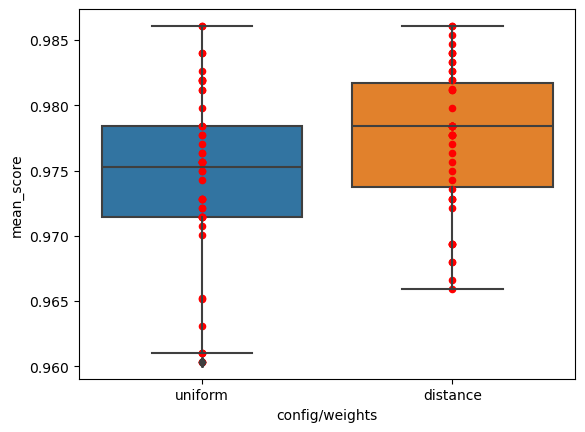

In [100]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
import seaborn as sns
sns.boxplot(data=dfi, x='config/weights', y='mean_score', ax=ax)
dfi.plot(x='config/weights', y='mean_score', ax=ax, kind='scatter', c='red')

以上的结果并没有控制变量，是直接进行了一个统计。相关性不代表因果性，所以上面的结果仅仅代表了在我们调参采样过程中，自变量“weights”与因变量“mean_score”的一定的相关性。
如果我们不知道每一次实验具体的其他的无关变量，上面的图我们也可以做一个合理的假设检验（验证我们的实验假设的零假设是否要拒绝！）。
根据论文，

/home/ycm/program_files/managers/conda/envs/hf_ai/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1345: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<Axes: xlabel='config/weights', ylabel='mean_score'>

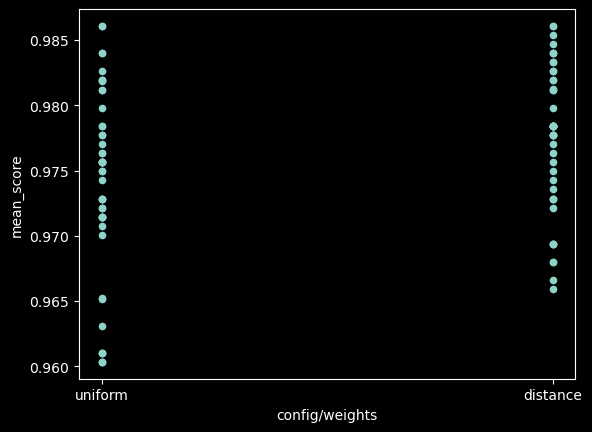